In [2]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import joblib
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

In [4]:
file_path = os.listdir("dataset")
print(len(file_path))

4738


In [6]:
train_files, test_files = train_test_split(file_path, test_size=0.15)
print(len(train_files))
print(len(test_files))

train_files = pd.DataFrame(train_files, columns=["filepath"])
test_files = pd.DataFrame(test_files, columns=["filepath"])

train_files.to_csv("./train_file.csv", index=False)
test_files.to_csv("./test_file.csv",index=False)

4027
711


In [7]:
train_files = list(pd.read_csv("./train_file.csv")["filepath"])
test_files = list(pd.read_csv("./test_file.csv")["filepath"])

In [15]:
img = cv2.imread("./dataset/"+train_files[0])

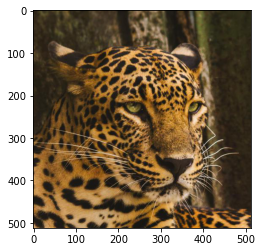

In [16]:

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img.shape

In [19]:
def image2array(file_array):

    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for path in tqdm(file_array):
        img = cv2.imread('./dataset/'+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3) 
    image_array = image_array.astype('float32')
    image_array /= 255 
    return np.array(image_array)

In [20]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)


Length of training dataset: (4027, 224, 224, 3)



Length of test dataset: (711, 224, 224, 3)


In [21]:
def encoder_decoder_model():

    """
    Used to build Convolutional Autoencoder model architecture to get compressed image data which is easier to process.
    Returns:
    Auto encoder model
    """
    #Encoder 
    model = Sequential(name='Convolutional_AutoEncoder_Model')
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
    #Decoder
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
    model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))
    return model

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None,

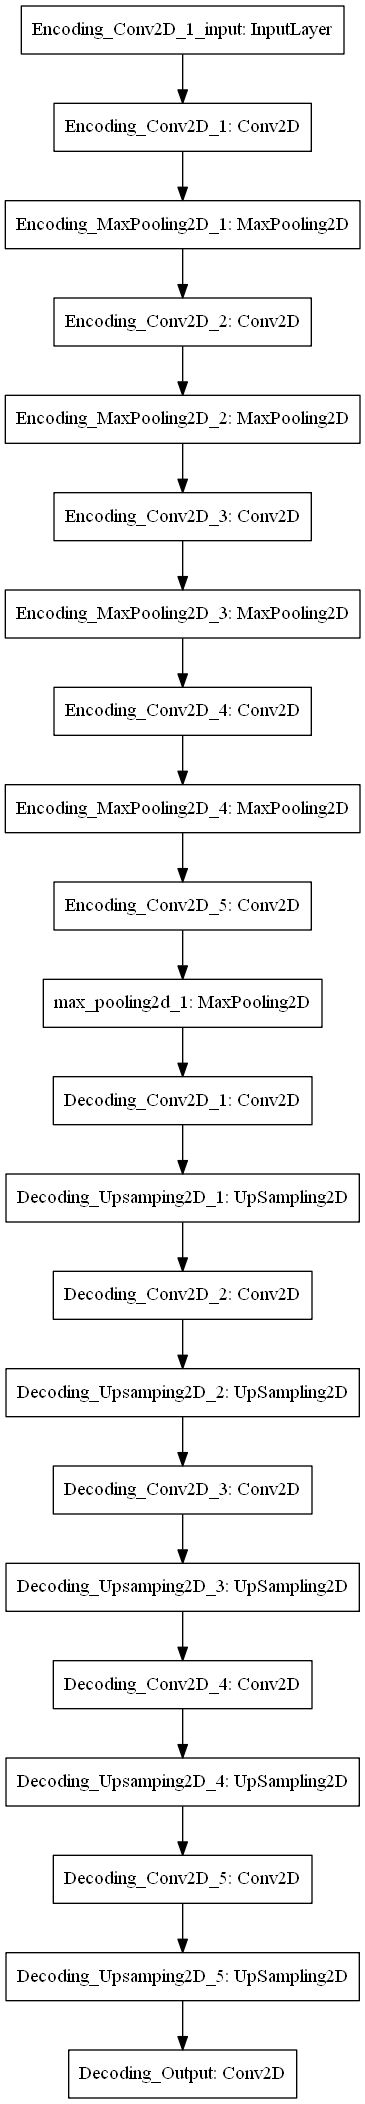

In [23]:
model = encoder_decoder_model()
model.summary()
print("\n")
tf.keras.utils.plot_model(model, to_file='./AE_model.png')

In [24]:
parameters = {'Adagrad':[0.01,0.001,0.0001,0.00001],'Adam':[0.01,0.001,0.0001,0.00001],'Rmsprop':[0.01,0.001,0.0001,0.00001]}
result = []
for i in parameters.keys():
    print("{} as an optimizer:".format(i))
    values = parameters[i]
    result_ = []
    for learning_rate in values:
        print("\t\tUsing learning_rate: "+str(learning_rate))
        model = encoder_decoder_model()
        if i=='Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif i=='Adagrad':
            optimizer = Adagrad(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')             # compiling 
        model.fit(train_data, train_data, epochs=5, batch_size=32,validation_data=(test_data,test_data))  # fitting data
        result_.append(model.history.history)           # taking result to judge the best parameters.
    print()
    result.append(result_)

Adagrad as an optimizer:
		Using learning_rate: 0.01
Epoch 1/5
126/126 [==============================] - 18s 144ms/step - loss: 2.2561 - val_loss: 2.2372
Epoch 2/5
126/126 [==============================] - 17s 135ms/step - loss: 2.2191 - val_loss: 2.2013
Epoch 3/5
126/126 [==============================] - 17s 132ms/step - loss: 2.1840 - val_loss: 2.1667
Epoch 4/5
126/126 [==============================] - 17s 138ms/step - loss: 2.1498 - val_loss: 2.1328
Epoch 5/5
126/126 [==============================] - 17s 137ms/step - loss: 2.1161 - val_loss: 2.0993
		Using learning_rate: 0.001
Epoch 1/5
126/126 [==============================] - 17s 138ms/step - loss: 2.2723 - val_loss: 2.2705
Epoch 2/5
126/126 [==============================] - 17s 137ms/step - loss: 2.2684 - val_loss: 2.2667
Epoch 3/5
126/126 [==============================] - 17s 137ms/step - loss: 2.2646 - val_loss: 2.2628
Epoch 4/5
126/126 [==============================] - 17s 137ms/step - loss: 2.2607 - val_loss: 2.2590


In [25]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

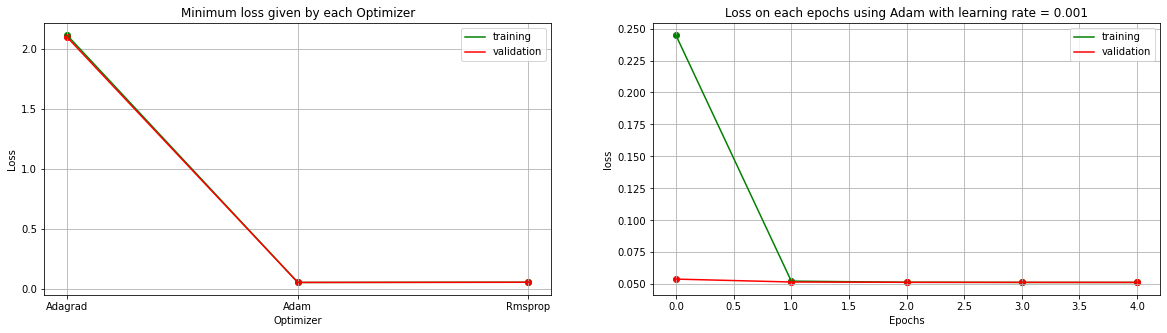

In [26]:

min_train = []; min_val = []  
rates = list(parameters.keys())
epochs = [0,1,2,3,4]
for i in result:
    train = []; val = []
    for j in i:
        train.append(min(j['loss'])); val.append(min(j['val_loss']))  # taking minimum loss of each optimizer over all learning rates.
    min_train.append(min(train)); min_val.append(min(val))
plt.figure(figsize=(20,5))
plot_(rates,min_train,min_val,1,2,1,'Minimum loss given by each Optimizer','Optimizer','Loss','training',False,'r')
# plotting the result of adam with learning rate = 0.001 .
plot_(epochs, result[1][1]['loss'],result[1][1]['val_loss'],1,2,2,'Loss on each epochs using Adam with learning rate = 0.001','Epochs','loss','training',False,'r')
plt.show()

In [30]:

optimizer = Adam(learning_rate=0.001) 
model = encoder_decoder_model() 
model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001) 
checkpoint = ModelCheckpoint('./encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=35, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint])

Epoch 1/35
126/126 [==============================] - 17s 134ms/step - loss: 0.2259 - val_loss: 0.0517
Epoch 2/35
126/126 [==============================] - 17s 133ms/step - loss: 0.0515 - val_loss: 0.0515
Epoch 3/35
126/126 [==============================] - 17s 136ms/step - loss: 0.0514 - val_loss: 0.0515
Epoch 4/35
126/126 [==============================] - 17s 137ms/step - loss: 0.0514 - val_loss: 0.0516
Epoch 5/35
126/126 [==============================] - 17s 131ms/step - loss: 0.0514 - val_loss: 0.0516
Epoch 6/35
126/126 [==============================] - 17s 132ms/step - loss: 0.0514 - val_loss: 0.0515
Epoch 7/35
126/126 [==============================] - 17s 132ms/step - loss: 0.0514 - val_loss: 0.0515
Epoch 8/35
126/126 [==============================] - 17s 134ms/step - loss: 0.0514 - val_loss: 0.0515
Epoch 00008: early stopping


In [31]:
plt.figure(figsize=(15,5))
epochs = [i for i in range(34)]
plot_(epochs,loss,'',1,2,1,'Training loss on each epoch','Epoch','Loss','training',False,'g')
plot_(epochs,val_loss,'',1,2,2,'validation loss on each epoch','Epoch','Loss','testing',False,'r')

NameError: name 'loss' is not defined

# Model Test